In [27]:
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Auto select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------------------------------
# Load metadata
# ---------------------------------------------------
with open("/kaggle/input/cub2002011/CUB_200_2011/train_test_split.txt") as f:
    split = dict(line.strip().split() for line in f)

with open("/kaggle/input/cub2002011/CUB_200_2011/images.txt") as f:
    paths = dict(line.strip().split() for line in f)

with open("/kaggle/input/cub2002011/CUB_200_2011/image_class_labels.txt") as f:
    labels = dict(line.strip().split() for line in f)

# ---------------------------------------------------
# Select only FIRST 5 classes
# ---------------------------------------------------
selected_classes = set(list({int(v) for v in labels.values()})[:200])

print("Using classes:", selected_classes)

train_paths, train_labels = [], []
test_paths, test_labels = [], []

base = "/kaggle/input/cub2002011/CUB_200_2011/images/"

for img_id, rel in paths.items():
    cls = int(labels[img_id])
    if cls not in selected_classes:
        continue

    full = base + rel
    if split[img_id] == "1":
        train_paths.append(full)
        train_labels.append(cls)
    else:
        test_paths.append(full)
        test_labels.append(cls)

print("Train images:", len(train_paths))
print("Test images :", len(test_paths))

# ---------------------------------------------------
# Convert to DataFrames (path + class)
# ---------------------------------------------------
train_df = pd.DataFrame({"path": train_paths, "class": train_labels})
test_df  = pd.DataFrame({"path": test_paths , "class": test_labels})

# ---------------------------------------------------
# Per-class sample counts
# ---------------------------------------------------

train_count = train_df["class"].value_counts().sort_index()
test_count  = test_df["class"].value_counts().sort_index()

print("\n===== TRAIN PER-CLASS COUNTS =====")
print(train_count)

print("\n===== TEST PER-CLASS COUNTS =====")
print(test_count)

print("\n===== SUMMARY =====")
print("Train: classes =", train_count.index.nunique(),
      "| min =", train_count.min(),
      "| max =", train_count.max(),
      "| avg =", train_count.mean())

print("Test : classes =", test_count.index.nunique(),
      "| min =", test_count.min(),
      "| max =", test_count.max(),
      "| avg =", test_count.mean())

# ---------------------------------------------------
# Dataset class with transforms
# ---------------------------------------------------
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class CUBDataset(Dataset):
    def __init__(self, df, transform):
        self.paths = df["path"].values
        self.labels = df["class"].values
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transform(img)
        cls = self.labels[idx] - 1
        return img, cls

# ---------------------------------------------------
# Dataloaders
# ---------------------------------------------------
train_dataset = CUBDataset(train_df, transform_train)
test_dataset = CUBDataset(test_df, transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset , batch_size=32, shuffle=False, num_workers=2)

print("Train loader batches:", len(train_loader))
print("Test loader batches :", len(test_loader))

Using device: cuda
Using classes: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200}
Train images: 5994
Test images : 5794

===== TRAIN PER-CLASS COUNTS =====

Using device: cuda
PyTorch: 2.6.0+cu124
Epoch 1/10 | Loss: 4.4764
Epoch 2/10 | Loss: 2.3309
Epoch 3/10 | Loss: 1.5234
Epoch 4/10 | Loss: 1.0799
Epoch 5/10 | Loss: 0.8110
Epoch 6/10 | Loss: 0.6239
Epoch 7/10 | Loss: 0.4839
Epoch 8/10 | Loss: 0.3821
Epoch 9/10 | Loss: 0.3197
Epoch 10/10 | Loss: 0.2581

========== EVALUATION ==========
Recall@1 = 0.6414
Recall@2 = 0.7316
Recall@4 = 0.8082
Recall@8 = 0.8728
NMI = 0.7703
F1 = 0.006826
Precision = 0.009912
Recall = 0.981315


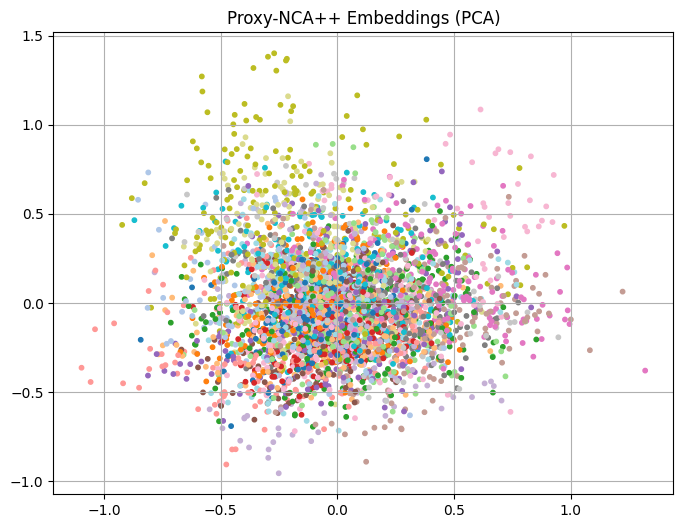

In [29]:
# --------------------------------------------------------------
# 1. CRITICAL: NO FILE NAMED torch.py IN THIS FOLDER!
# --------------------------------------------------------------

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, f1_score, pairwise_distances
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# FIXED: This now works
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("PyTorch:", torch.__version__)

# --------------------------------------------------------------
# 2. MODEL: Simple AutoEncoder
# --------------------------------------------------------------
class SimpleMetricAutoEncoder(nn.Module):
    def __init__(self, embed_dim=128):
        super().__init__()
        goog = models.googlenet(weights="IMAGENET1K_V1")
        self.backbone = nn.Sequential(
            goog.conv1, goog.maxpool1,
            goog.conv2, goog.conv3, goog.maxpool2,
            goog.inception3a, goog.inception3b, goog.maxpool3,
            goog.inception4a, goog.inception4b, goog.inception4c,
            goog.inception4d, goog.inception4e,
            goog.maxpool4,
            goog.inception5a, goog.inception5b,
            goog.avgpool
        )
        self.fc_embed = nn.Linear(1024, embed_dim)
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, 512), nn.ReLU(),
            nn.Linear(512, 1024)
        )

    def extract_f(self, x):
        f = self.backbone(x)
        return f.view(f.size(0), -1)

    def forward(self, x):
        f = self.extract_f(x)
        z = self.fc_embed(f)
        f_hat = self.decoder(z)
        return z, f, f_hat

# --------------------------------------------------------------
# 3. Proxy-NCA++ Loss (SOTA)
# --------------------------------------------------------------
class ProxyNCAPlusPlus(nn.Module):
    def __init__(self, embed_dim, num_classes, num_pos=3, temp=0.1):
        super().__init__()
        self.proxies = nn.Parameter(torch.randn(num_classes, num_pos, embed_dim))
        nn.init.xavier_uniform_(self.proxies)
        self.temp = temp

    def forward(self, embedding, label):
        embedding = F.normalize(embedding, dim=1)
        proxies = F.normalize(self.proxies, dim=-1)

        label = label.view(-1, 1)
        pos_proxies = proxies[label.squeeze(1)]  # (B, K, D)

        sim_pos = torch.bmm(pos_proxies, embedding.unsqueeze(-1)).squeeze(-1) / self.temp
        sim_pos = sim_pos.max(dim=1)[0]

        all_proxies = proxies.view(-1, embedding.size(1))
        sim_all = F.linear(embedding, all_proxies) / self.temp
        logsumexp = torch.logsumexp(sim_all, dim=1)

        return -(sim_pos - logsumexp).mean()

# --------------------------------------------------------------
# 4. Reconstruction Loss
# --------------------------------------------------------------
def recon_loss(f, f_hat):
    return F.mse_loss(f_hat, f)

# --------------------------------------------------------------
# 5. Setup
# --------------------------------------------------------------
num_classes = 200
model = SimpleMetricAutoEncoder(embed_dim=128).to(device)
proxy_nca = ProxyNCAPlusPlus(128, num_classes, num_pos=3, temp=0.1).to(device)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(proxy_nca.parameters()),
    lr=1e-4
)

# --------------------------------------------------------------
# 6. TRAIN LOOP
# --------------------------------------------------------------
EPOCHS = 10
λ_recon = 1.0
λ_nca = 1.0

for epoch in range(EPOCHS):
    model.train()
    proxy_nca.train()
    epoch_loss = 0.0
    n_batches = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        z, f, f_hat = model(imgs)
        L_recon = recon_loss(f, f_hat)
        L_nca = proxy_nca(z, labels)

        loss = λ_recon * L_recon + λ_nca * L_nca

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        n_batches += 1

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {epoch_loss/n_batches:.4f}")

# --------------------------------------------------------------
# 7. Extract Embeddings
# --------------------------------------------------------------
@torch.no_grad()
def extract_embeddings(model, loader):
    model.eval()
    E, L = [], []
    for imgs, lbls in loader:
        imgs = imgs.to(device)
        z, _, _ = model(imgs)
        E.append(z.cpu())
        L.append(lbls.cpu())
    return torch.cat(E), torch.cat(L)

E, L = extract_embeddings(model, test_loader)

# --------------------------------------------------------------
# 8. Evaluation
# --------------------------------------------------------------
def recall_at_k(E, L, K=1):
    E = F.normalize(E, dim=1)
    sim = E @ E.t()
    N = len(L)
    sim[range(N), range(N)] = -1
    _, idx = sim.topk(K, dim=1)
    return sum(L[i] in L[idx[i]] for i in range(N)) / N

def clustering_metrics(E, L, num_classes):
    km = KMeans(n_clusters=num_classes, n_init=10, random_state=0)
    clusters = km.fit_predict(E)
    nmi = normalized_mutual_info_score(L, clusters)
    f1 = f1_score(L, clusters, average="macro")
    return nmi, f1

def pairwise_precision_recall(E, L):
    D = pairwise_distances(E)
    y_true = (L[:, None] == L[None, :]).astype(int)
    thr = np.median(D)
    y_pred = (D < thr).astype(int)
    TP = (y_pred * y_true).sum()
    FP = (y_pred * (1 - y_true)).sum()
    FN = ((1 - y_pred) * y_true).sum()
    prec = TP / (TP + FP + 1e-9)
    rec = TP / (TP + FN + 1e-9)
    return prec, rec

print("\n========== EVALUATION ==========")
for k in [1, 2, 4, 8]:
    print(f"Recall@{k} = {recall_at_k(E, L, k):.4f}")

nmi, f1 = clustering_metrics(E.numpy(), L.numpy(), len(torch.unique(L)))
print(f"NMI = {nmi:.4f}")
print(f"F1 = {f1:.6f}")

prec, rec = pairwise_precision_recall(E.numpy(), L.numpy())
print(f"Precision = {prec:.6f}")
print(f"Recall = {rec:.6f}")

# --------------------------------------------------------------
# 9. PCA Plot
# --------------------------------------------------------------
def plot_pca(E, L, n=4000):
    E_np, L_np = E.numpy(), L.numpy()
    if len(E_np) > n:
        idx = np.random.choice(len(E_np), n, replace=False)
        E_np, L_np = E_np[idx], L_np[idx]
    X = PCA(2).fit_transform(E_np)
    plt.figure(figsize=(8,6))
    plt.scatter(X[:,0], X[:,1], c=L_np, cmap='tab20', s=10)
    plt.title("Proxy-NCA++ Embeddings (PCA)")
    plt.grid(True)
    plt.show()

plot_pca(E, L)

Using device: cuda
Using classes: 200
Train batches: 188
Test batches: 182


Epoch 1/10: 100%|██████████| 188/188 [00:26<00:00,  7.13it/s]


Epoch 01 | Avg loss: 9.2332


Epoch 2/10: 100%|██████████| 188/188 [00:26<00:00,  7.19it/s]


Epoch 02 | Avg loss: 7.0507


Epoch 3/10: 100%|██████████| 188/188 [00:25<00:00,  7.34it/s]


Epoch 03 | Avg loss: 6.0409


Epoch 4/10: 100%|██████████| 188/188 [00:25<00:00,  7.28it/s]


Epoch 04 | Avg loss: 5.5179


Epoch 5/10: 100%|██████████| 188/188 [00:25<00:00,  7.23it/s]


Epoch 05 | Avg loss: 5.2216


Epoch 6/10: 100%|██████████| 188/188 [00:25<00:00,  7.27it/s]


Epoch 06 | Avg loss: 5.0455


Epoch 7/10: 100%|██████████| 188/188 [00:25<00:00,  7.29it/s]


Epoch 07 | Avg loss: 4.9041


Epoch 8/10: 100%|██████████| 188/188 [00:25<00:00,  7.27it/s]


Epoch 08 | Avg loss: 4.8073


Epoch 9/10: 100%|██████████| 188/188 [00:25<00:00,  7.25it/s]


Epoch 09 | Avg loss: 4.7283


Epoch 10/10: 100%|██████████| 188/188 [00:25<00:00,  7.28it/s]

Epoch 10 | Avg loss: 4.6843



========== METRIC LEARNING EVALUATION ==========
Recall@1 = 0.6241
Recall@2 = 0.7302
Recall@4 = 0.8096
Recall@8 = 0.8718

NMI = 0.7710
F1 = 0.009171

Pairwise Precision = 0.009927
Pairwise Recall = 0.982719


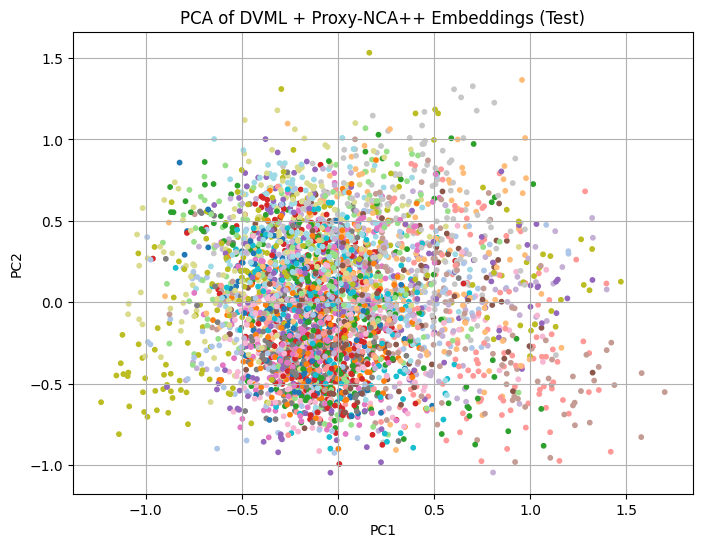

In [32]:
# --------------------------------------------------------------
# 1. Imports & device
# --------------------------------------------------------------
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
import random
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, f1_score, pairwise_distances
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------------------------------------------------
# 2. Load metadata
# --------------------------------------------------------------
with open("/kaggle/input/cub2002011/CUB_200_2011/train_test_split.txt") as f:
    split = dict(line.strip().split() for line in f)
with open("/kaggle/input/cub2002011/CUB_200_2011/images.txt") as f:
    paths = dict(line.strip().split() for line in f)
with open("/kaggle/input/cub2002011/CUB_200_2011/image_class_labels.txt") as f:
    labels = dict(line.strip().split() for line in f)

# --------------------------------------------------------------
# 3. Select first 200 classes
# --------------------------------------------------------------
selected_classes = set(list({int(v) for v in labels.values()})[:200])
print("Using classes:", len(selected_classes))

train_paths, train_labels = [], []
test_paths, test_labels = [], []
base = "/kaggle/input/cub2002011/CUB_200_2011/images/"

for img_id, rel in paths.items():
    cls = int(labels[img_id])
    if cls not in selected_classes: continue
    full = base + rel
    if split[img_id] == "1":
        train_paths.append(full); train_labels.append(cls)
    else:
        test_paths.append(full); test_labels.append(cls)

train_df = pd.DataFrame({"path": train_paths, "class": train_labels})
test_df = pd.DataFrame({"path": test_paths, "class": test_labels})

# --------------------------------------------------------------
# 4. Transforms & Dataset
# --------------------------------------------------------------
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CUBDataset(Dataset):
    def __init__(self, df, transform):
        self.paths = df["path"].values
        self.labels = df["class"].values
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transform(img)
        cls = self.labels[idx] - 1  # 0-based
        return img, cls

train_dataset = CUBDataset(train_df, transform_train)
test_dataset = CUBDataset(test_df, transform_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
print("Train batches:", len(train_loader))
print("Test batches:", len(test_loader))

# --------------------------------------------------------------
# 5. DVML Network
# --------------------------------------------------------------
class DVML(nn.Module):
    def __init__(self, embed_dim=128, T=20):
        super().__init__()
        goog = models.googlenet(weights="IMAGENET1K_V1")
        self.backbone = nn.Sequential(
            goog.conv1, goog.maxpool1,
            goog.conv2, goog.conv3, goog.maxpool2,
            goog.inception3a, goog.inception3b, goog.maxpool3,
            goog.inception4a, goog.inception4b, goog.inception4c,
            goog.inception4d, goog.inception4e,
            goog.maxpool4,
            goog.inception5a, goog.inception5b,
            goog.avgpool
        )
        self.fc_I = nn.Linear(1024, embed_dim)
        self.fc_mu = nn.Linear(1024, embed_dim)
        self.fc_logvar = nn.Linear(1024, embed_dim)
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, 512), nn.ReLU(),
            nn.Linear(512, 1024)
        )
        self.T = T
        self.embed_dim = embed_dim

    def encode(self, x):
        f = self.backbone(x).view(x.size(0), -1)
        z_I = self.fc_I(f)
        mu = self.fc_mu(f)
        logvar = self.fc_logvar(f)
        return z_I, mu, logvar, f

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, train=True):
        z_I, mu, logvar, f = self.encode(x)
        if not train:
            f_hat = self.decoder(z_I)
            return z_I, f, f_hat
        z_V = self.reparameterize(mu, logvar)
        z_V = z_V.unsqueeze(1).repeat(1, self.T, 1)
        z_I_rep = z_I.unsqueeze(1).repeat(1, self.T, 1)
        z_hat = z_I_rep + z_V
        z_hat_flat = z_hat.view(-1, self.embed_dim)
        f_hat_flat = self.decoder(z_hat_flat)
        return z_I, f, f_hat_flat, z_hat_flat, mu, logvar

# --------------------------------------------------------------
# 6. Proxy-NCA++ Loss
# --------------------------------------------------------------
class ProxyNCAPlusPlus(nn.Module):
    def __init__(self, embed_dim, num_classes, num_pos=3, temp=0.1):
        super().__init__()
        self.proxies = nn.Parameter(torch.randn(num_classes, num_pos, embed_dim))
        nn.init.xavier_uniform_(self.proxies)
        self.temp = temp
        self.num_pos = num_pos

    def forward(self, embedding, label):
        embedding = F.normalize(embedding, dim=1)  # (B, D)
        proxies = F.normalize(self.proxies, dim=-1)  # (C, K, D)

        B, D = embedding.shape
        C, K = proxies.shape[0], proxies.shape[1]

        # Expand label to (B, K)
        label = label.unsqueeze(1).expand(B, K)

        # Gather positive proxies
        pos_proxies = proxies[label, torch.arange(K).to(device)]  # (B, K, D)

        # Max similarity to any positive proxy
        sim_pos = torch.bmm(pos_proxies, embedding.unsqueeze(-1)).squeeze(-1) / self.temp
        sim_pos = sim_pos.max(dim=1)[0]

        # Similarity to all proxies
        all_proxies = proxies.view(-1, D)
        sim_all = F.linear(embedding, all_proxies) / self.temp
        logsumexp = torch.logsumexp(sim_all, dim=1)

        return -(sim_pos - logsumexp).mean()

# --------------------------------------------------------------
# 7. Helper loss functions
# --------------------------------------------------------------
def recon_loss(f, f_hat, T):
    return F.mse_loss(f_hat, f.repeat(T, 1)) / T

def kl_divergence(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

# --------------------------------------------------------------
# 8. Model, Proxy-NCA++, Optimizer
# --------------------------------------------------------------
num_classes = len(selected_classes)  # 200
embed_dim = 128
T = 20
num_pos_proxies = 3
temperature = 0.1

model = DVML(embed_dim=embed_dim, T=T).to(device)
proxy_nca_I = ProxyNCAPlusPlus(embed_dim, num_classes, num_pos=num_pos_proxies, temp=temperature).to(device)
proxy_nca_hat = ProxyNCAPlusPlus(embed_dim, num_classes, num_pos=num_pos_proxies, temp=temperature).to(device)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(proxy_nca_I.parameters()) + list(proxy_nca_hat.parameters()),
    lr=1e-4
)

# --------------------------------------------------------------
# 9. Training loop – DVML + Proxy-NCA++
# --------------------------------------------------------------
EPOCHS = 10
λ_kl = 0.1
λ_recon = 1.0
λ_metric_I = 1.0
λ_metric_hat = 0.8

for epoch in range(1, EPOCHS + 1):
    model.train()
    proxy_nca_I.train()
    proxy_nca_hat.train()
    epoch_loss = 0.0
    n_batches = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        imgs = imgs.to(device)
        labels = labels.to(device)

        z_I, f, f_hat_flat, z_hat_flat, mu, logvar = model(imgs, train=True)

        # Losses
        L_kl = kl_divergence(mu, logvar)
        L_recon = recon_loss(f, f_hat_flat, T=T)
        L_metric_I = proxy_nca_I(z_I, labels)
        labels_hat = labels.repeat(T)
        L_metric_hat = proxy_nca_hat(z_hat_flat, labels_hat)

        loss = (λ_kl * L_kl +
                λ_recon * L_recon +
                λ_metric_I * L_metric_I +
                λ_metric_hat * L_metric_hat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        n_batches += 1

    print(f"Epoch {epoch:02d} | Avg loss: {epoch_loss / n_batches:.4f}")

# --------------------------------------------------------------
# 10. Extract embeddings (z_I only)
# --------------------------------------------------------------
@torch.no_grad()
def extract_embeddings(loader):
    model.eval()
    E, L = [], []
    for imgs, lbls in loader:
        imgs = imgs.to(device)
        z_I, _, _ = model(imgs, train=False)
        E.append(z_I.cpu())
        L.append(lbls.cpu())
    return torch.cat(E), torch.cat(L)

E, L = extract_embeddings(test_loader)

# --------------------------------------------------------------
# 11. Evaluation
# --------------------------------------------------------------
def recall_at_k(E, L, K=1):
    E = F.normalize(E, dim=1)
    sim = E @ E.t()
    N = len(L)
    sim[range(N), range(N)] = -1
    _, idx = sim.topk(K, dim=1)
    return sum(L[i] in L[idx[i]] for i in range(N)) / N

def clustering_metrics(E, L, num_classes):
    km = KMeans(n_clusters=num_classes, n_init=10, random_state=0)
    clusters = km.fit_predict(E)
    nmi = normalized_mutual_info_score(L, clusters)
    f1 = f1_score(L, clusters, average="macro")
    return nmi, f1

def pairwise_precision_recall(E, L):
    D = pairwise_distances(E)
    y_true = (L[:, None] == L[None, :]).astype(int)
    thr = np.median(D)
    y_pred = (D < thr).astype(int)
    TP = (y_pred * y_true).sum()
    FP = (y_pred * (1 - y_true)).sum()
    FN = ((1 - y_pred) * y_true).sum()
    prec = TP / (TP + FP + 1e-9)
    rec = TP / (TP + FN + 1e-9)
    return prec, rec

num_classes = len(torch.unique(L))
print("\n========== METRIC LEARNING EVALUATION ==========")
for k in [1, 2, 4, 8]:
    print(f"Recall@{k} = {recall_at_k(E, L, k):.4f}")

nmi, f1 = clustering_metrics(E.numpy(), L.numpy(), num_classes)
print(f"\nNMI = {nmi:.4f}")
print(f"F1 = {f1:.6f}")

prec, rec = pairwise_precision_recall(E.numpy(), L.numpy())
print(f"\nPairwise Precision = {prec:.6f}")
print(f"Pairwise Recall = {rec:.6f}")

# --------------------------------------------------------------
# 12. PCA Visualization
# --------------------------------------------------------------
def plot_pca_clusters(E, L, num_samples=4000):
    E_np = E.numpy(); L_np = L.numpy()
    if len(E_np) > num_samples:
        idx = np.random.choice(len(E_np), num_samples, replace=False)
        E_np, L_np = E_np[idx], L_np[idx]
    X = PCA(n_components=2).fit_transform(E_np)
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=L_np, cmap="tab20", s=10)
    plt.title("PCA of DVML + Proxy-NCA++ Embeddings (Test)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

plot_pca_clusters(E, L)